# Oferta e Demanda

In [30]:
import pandas as pd
import numpy as np
import json
import importlib, sys, os, requests
from datetime import date, datetime
from bs4 import BeautifulSoup

from pathlib import Path
sys.path.append(str(Path(os.path.abspath('')).parents[0]))

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import yfinance as yf
import investpy

import support_library as sl

_ = [importlib.reload(sys.modules[m]) for m in list(sys.modules) if 'support_library' in m]

In [48]:
DATE_FORMAT = '%Y-%m-%d'
MIN_DATE    = "2010-01-01"
TODAY       = date.today()
TODAY_STR   = date.today().strftime(DATE_FORMAT)
REF_MES     = 12 
THIS_YEAR   = "2022-01-01"

DATASET     = r'../dataset/'

TODAY

datetime.date(2022, 3, 30)

# Preco Soja

In [3]:
df_soja = sl.soybean.get_all_prices()
print(df_soja.shape)
df_soja.head()

(3043, 13)


,sb_grain_future_price,sb_grain_future_volume,sb_grain_spot_price,sb_grain_spot_volume,sb_oil_future_price,sb_oil_future_volume,sb_oil_spot_price,sb_oil_spot_volume,sb_meal_future_price,sb_meal_future_volume,sb_meal_spot_price,sb_meal_spot_volume,date
Date,,,,,,,,,,,,,
2010-01-04,385.63,25947,388.75,87661.0,901.69,24855.0,910.29,51055.0,348.33,3802.0,339.84,22970.0,2010-01-04
2010-01-05,386.64,21073,389.85,63725.0,897.50,10840.0,906.10,26802.0,352.08,3162.0,343.26,16625.0,2010-01-05
2010-01-06,385.99,17567,389.12,63223.0,896.62,9257.0,905.44,35365.0,350.42,2183.0,341.94,16785.0,2010-01-06
2010-01-07,373.96,11750,376.99,88966.0,881.63,4976.0,889.79,147.0,338.41,3298.0,328.71,285.0,2010-01-07
2010-01-08,372.21,11750,375.52,73190.0,871.49,4976.0,879.87,35634.0,338.19,3298.0,328.82,24729.0,2010-01-08


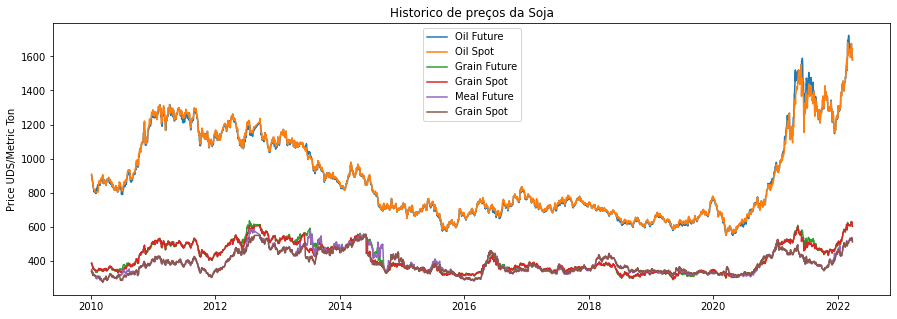

In [4]:
plt.figure(figsize=(15,5))

plt.plot(df_soja.index, df_soja['sb_oil_future_price'], label='Oil Future', );
plt.plot(df_soja.index, df_soja['sb_oil_spot_price'], label='Oil Spot');
plt.plot(df_soja.index, df_soja['sb_grain_future_price'], label='Grain Future');
plt.plot(df_soja.index, df_soja['sb_grain_spot_price'], label='Grain Spot');
plt.plot(df_soja.index, df_soja['sb_meal_future_price'], label='Meal Future');
plt.plot(df_soja.index, df_soja['sb_meal_spot_price'], label='Grain Spot');
plt.title("Historico de preços da Soja")
plt.ylabel('Price UDS/Metric Ton')
plt.legend(loc='best');

In [6]:
df_soja.to_csv(f'{DATASET}\__preco_soja.csv')
sl.save_excel(df_soja, f'{DATASET}\__preco_soja.xlsx')

# Preço Girassol

In [49]:
with open(f'{DATASET}/ychart_sunflower_oil_price.json') as f:
    d = json.load(f)
    
df_temp = pd.DataFrame(d['chart_data'][0][0]['raw_data'], columns = ['date', 'sunflower_oil_price'])
df_temp['date'] = pd.to_datetime(df_temp['date'], unit='ms')
df_temp['date'] = df_temp['date'] + pd.DateOffset(1)  + pd.DateOffset(months=-1)
# df_temp['date'] = df_temp['date'].dt.strftime('%Y-%m-%d')
df_temp.set_index('date', inplace=True)
df_temp['sunflower_oil_price'] = df_temp['sunflower_oil_price'] * 19.6841
df_sun = df_temp



with open(f'{DATASET}/ychart_sunflower_oil_export_price.json') as f:
    d = json.load(f)
    
df_temp = pd.DataFrame(d['chart_data'][0][0]['raw_data'], columns = ['date', 'sunflower_oil_export_price'])
df_temp['date'] = pd.to_datetime(df_temp['date'], unit='ms')
df_temp['date'] = df_temp['date'] + pd.DateOffset(1)  + pd.DateOffset(months=-1)
df_temp.set_index('date', inplace=True)
df_sun = pd.merge(df_sun, df_temp, how="outer", left_index=True, right_index=True)



# https://www.insee.fr/en/statistiques/serie/010753754#Telechargement
df_temp = pd.read_excel(f'{DATASET}/insee_sunflower_price.xlsx', sheet_name='monthly_values', header=3)
df_temp.columns = ['date', 'insee_price']
df_temp['date'] = pd.to_datetime(df_temp['date'])
df_temp.set_index('date', inplace=True)
df_sun = pd.merge(df_sun, df_temp, how="outer", left_index=True, right_index=True)



#https://fred.stlouisfed.org/series/PSUNOUSDM
from fredapi import Fred
fred = Fred(api_key='34226d58c6bcee68e056cb4c42b8f401')
df_temp = fred.get_series('PSUNOUSDM').to_frame()
df_temp.columns = ['fred_price']
df_sun = pd.merge(df_sun, df_temp, how="outer", left_index=True, right_index=True)




E:\Projetos\ITA_Tese\.env-win-tese\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [50]:
req = requests.get('https://www.sunflowernsa.com/growers/Marketing/daily-oilseed-sunflower-price/')
soup = BeautifulSoup(req.text)
tb = soup.find_all('table')[1]
tb = soup.find_all('table')[1]
df_temp = pd.read_html(str(tb))[0]
df_temp = df_temp.dropna(axis=1, how='all')
df_temp = df_temp.iloc[3:-3, :].copy()
df_temp = df_temp.dropna(axis=0, how='all')
df_temp = df_temp.replace(regex=[r'\$'], value='')
df_temp = df_temp.dropna(axis=1, how='all')
df_temp.columns = ['date', 'tipo1', 'tipo2', 'tipo3']
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%m/%d/%Y')
df_temp.set_index('date', inplace=True)
df_temp = df_temp.astype(float)
df_temp.dtypes
df_temp['average'] = round(df_temp.mean(axis=1),2)
df_temp['price'] = df_temp['average'] * 19.6841

df_temp = df_temp[['price']]
df_temp = df_temp[df_temp.index > pd.to_datetime(THIS_YEAR, format=DATE_FORMAT)]

df_sun = pd.merge(df_sun, df_temp, how="outer", left_index=True, right_index=True)

In [51]:
df_sun = df_sun[df_sun.index > pd.to_datetime(MIN_DATE, format=DATE_FORMAT)]
df_sun

,sunflower_oil_price,sunflower_oil_export_price,insee_price,fred_price,price
2010-02-01,583.043042,1091.4000,953.8,1091.400000,NaN
2010-03-01,545.840093,1105.2174,947.4,1105.217391,NaN
2010-04-01,514.739215,1132.7727,933.2,1132.772727,NaN
2010-05-01,498.598253,1102.5238,924.3,1102.523810,NaN
2010-06-01,543.478001,1090.3182,891.4,1090.318182,NaN
...,...,...,...,...,...
2022-03-21,NaN,NaN,NaN,NaN,746.421072
2022-03-23,NaN,NaN,NaN,NaN,747.405277
2022-03-24,NaN,NaN,NaN,NaN,747.405277
2022-03-25,NaN,NaN,NaN,NaN,747.405277


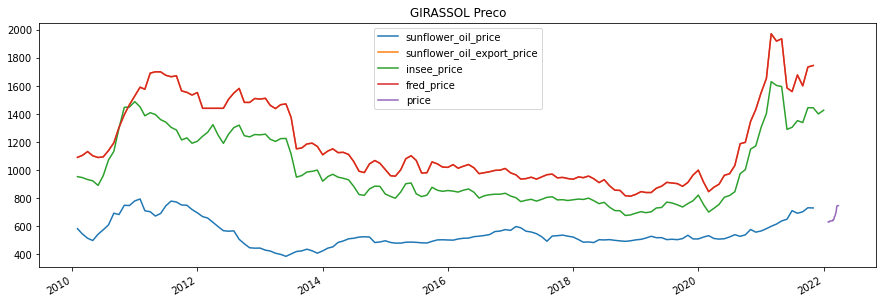

In [52]:
fig, axs = plt.subplots(figsize=(15,5))
df_sun.plot(ax = axs);
plt.title(f'GIRASSOL Preco');

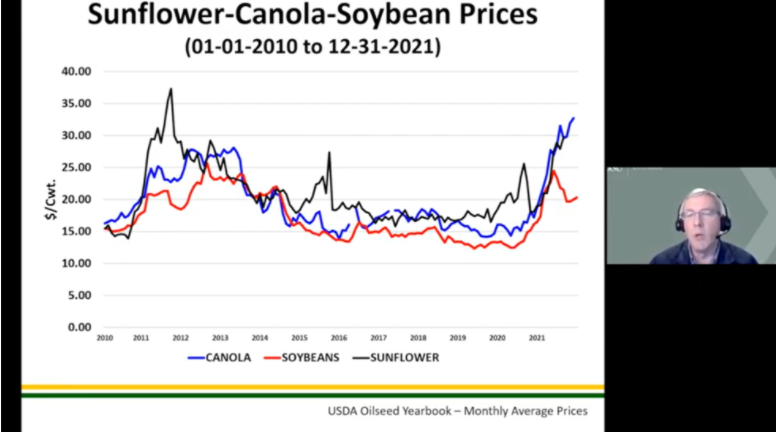

In [13]:
df_vol = df_soja[['sb_oil_spot_price', 'sb_oil_spot_volume']]
df_vol
df_vol

,sb_oil_spot_price,sb_oil_spot_volume
Date,,
2010-01-04,910.29,51055.0
2010-01-05,906.10,26802.0
2010-01-06,905.44,35365.0
2010-01-07,889.79,147.0
2010-01-08,879.87,35634.0
...,...,...
2022-03-23,1674.85,31251.0
2022-03-24,1637.81,35571.0
2022-03-25,1647.96,31999.0
